## Определение стоимости автомобиля

### 1. Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings as warn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Прочитаем файл *autos.csv* и сохраним его в переменной *autos*. Посмотрим таблицу и общую информацию о ней.

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Датафрейм содержит 354369 строк и 16 столбцов. Используемые типы данных: *int64* (7) и *object* (9). В 5 столбцах с типом *object* присутствуют пропуски, а в столбцах с числовыми данными — нереалистичные значения (например, мощность автомобиля, равная 0 л. с.). Это могло быть вызвано тем, что пользователи не указали часть данных, либо указали их неверно.

Вероятно, сервис позволяет пользователям редактировать анкеты, например, изменять цену автомобиля или дописывать не указанные ранее характеристики. В таком случае среди данных могут оказаться разные версии одних и тех же объявлений, фактически являющиеся дубликатами. Проверим это предположение.

Удалим столбцы с количеством фотографий и последней активностью пользователей, которые не пригодятся для дальнейшего использования.

In [4]:
autos.drop(['LastSeen', 'NumberOfPictures'], axis=1, inplace=True)

В данных отсутствует информация об уникальных идентификаторах анкет, однако дубликаты, скачанные из базы в разное время, можно определить по совпадению других характеристик.

In [5]:
columns_list = list(autos.columns)
columns_list.remove('DateCrawled')
autos.duplicated(columns_list).sum()

10194

Удалим найденные дубликаты.

In [6]:
autos.drop_duplicates(columns_list, inplace=True)
autos.duplicated(columns_list).sum()

0

Проверим, присутствуют ли в датафрейме разные версии одних и тех же анкет с дополненной информацией, на основе которой можно заполнить часть пропущеннных значений. Для этого предварительно создадим список столбцов, в которых есть пропуски, а также список оставшихся столбцов, исключая цену автомобиля, так как при редактировании анкеты она могла меняться.

In [7]:
nan_columns_list = list(autos.columns[autos.isna().sum() > 0])
nan_columns_list

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

In [8]:
for i in nan_columns_list:
    columns_list.remove(i)
columns_list.remove('Price')
columns_list

['RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'Brand',
 'DateCreated',
 'PostalCode']

In [9]:
autos[autos.duplicated(columns_list, keep=False)].sort_values(columns_list).head(6)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode
69320,2016-03-11 22:53:09,20,NaN,1910,NaN,0,NaN,5000,0,NaN,trabant,NaN,2016-03-11 00:00:00,6618
190238,2016-03-11 23:49:04,15,NaN,1910,NaN,0,NaN,5000,0,NaN,trabant,NaN,2016-03-11 00:00:00,6618
137324,2016-03-09 16:51:17,11500,convertible,1929,manual,15,other,5000,1,NaN,bmw,yes,2016-03-09 00:00:00,70569
230095,2016-03-09 16:52:31,11500,convertible,1929,manual,15,other,5000,1,petrol,bmw,yes,2016-03-09 00:00:00,70569
111211,2016-04-03 19:49:45,11444,sedan,1957,manual,60,other,125000,7,petrol,volvo,NaN,2016-04-03 00:00:00,90411
146816,2016-04-03 17:57:26,11444,sedan,1957,manual,60,other,125000,7,petrol,volvo,no,2016-04-03 00:00:00,90411


По полученному срезу данных видно, что описанные ранее записи действительно присутствуют. Создадм функцию *fill_duplicates*, которая для каждой строки с пропусками, имеющей дубликаты по столбцам из *columns_list*, найдёт эти дубликаты и на их основе заполнит недостающую информацию.

In [10]:
def fill_duplicates(row):
    # список столбцов с пропусками в row
    nans = list(row.index[row.isna()])
    # срез дубликатов row по columns_list
    duplicates = autos
    for i in columns_list:
        duplicates = duplicates[duplicates[i] == row[i]]
    # удаление row из среза
    duplicates = duplicates[duplicates.index != row.name]
    # список столбцов без пропусков среди nan_columns_list в row
    not_nans = nan_columns_list.copy()
    for i in nans:
        not_nans.remove(i)
    # срез дубликатов по not_nans (все непропущенные значения в столбцах not_nans должны совпадать)
    for i in not_nans:
        duplicates = duplicates[((duplicates[i].notna()) & (duplicates[i] == row[i])) | (duplicates[i].isna())]
    # заполнение пропусков значениями из среза дубликатов
    try:
        for i in range(len(duplicates)):
            autos.loc[row.name, :] = autos.loc[row.name, :].fillna(duplicates.iloc[i])
    except:
        pass

autos.loc[(autos.duplicated(columns_list, keep=False) & (autos.isna().any(1)))].apply(fill_duplicates, axis=1);

Посчитаем количество дубликатов по всем столбцам кроме *DateCrawled* и *Price* (в том числе возникшим в результате заполнения пропусков).

In [11]:
columns_list.extend(nan_columns_list)
autos.duplicated(columns_list).sum()

4018

Удалим найденные дубликаты, предварительно отсортировав срез по дате. Таким образом, среди продублированных анкет останутся только самые новые, имеющие наиболее актуальные данные о цене.

In [12]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])

warn.filterwarnings('ignore')
autos = autos.drop(index=autos[autos.sort_values('DateCrawled').duplicated(columns_list, keep='last')].index)
warn.filterwarnings('default')

autos.duplicated(columns_list).sum()

0

Удалим строки, содержащие все возможные пропуски, так как они содержат слишком мало информации. Также удалим столбцы, данные которых не могут повлиять на стоимость автомобилей.

In [13]:
mask = (autos['VehicleType'].isna() & 
        autos['Gearbox'].isna() & 
        autos['Model'].isna() & 
        autos['FuelType'].isna() &
        autos['NotRepaired'].isna())
autos.drop(index=autos[mask].index, inplace=True)
autos.drop(['DateCrawled', 
            'RegistrationMonth', 
            'DateCreated', 
            'PostalCode'], axis=1, inplace=True)

Исследуем количественные признаки.

In [14]:
autos.describe(percentiles=[.01, .25, .5, .75, .99])

,Price,RegistrationYear,Power,Kilometer
count,337981.000000,337981.000000,337981.000000,337981.000000
mean,4415.939278,2003.858838,110.500824,128451.924812
std,4512.066347,71.296358,192.916021,37599.789947
min,0.000000,1000.000000,0.000000,5000.000000
1%,0.000000,1980.000000,0.000000,5000.000000
25%,1080.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6399.000000,2008.000000,143.000000,150000.000000
99%,18800.000000,2018.000000,300.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В данных присутствуют выбросы, а также нереалистичные значения года регистрации, цены и мощности автомобилей. Исследуем распределения двух последних признаков.

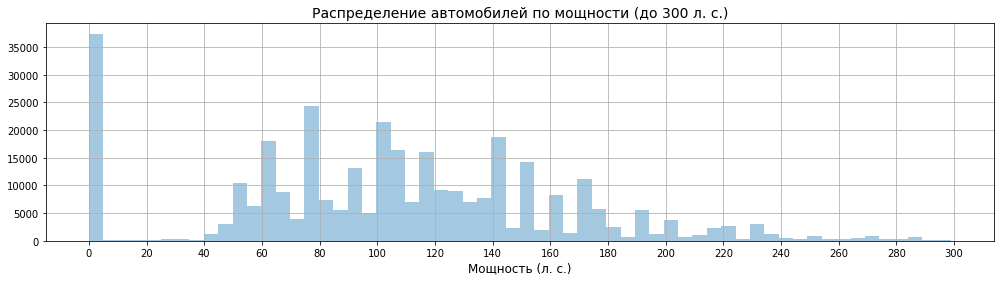

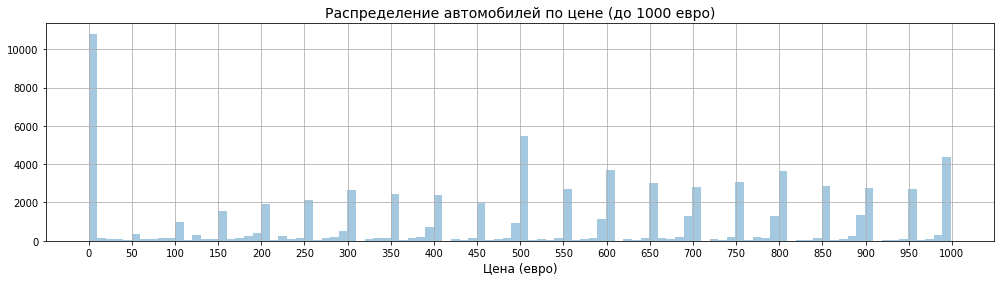

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(17, 4)
sns.distplot(autos.query('Power < 300')['Power'], ax=ax, bins=60, kde=False)
ax.set_title('Распределение автомобилей по мощности (до 300 л. с.)', fontsize=14)
ax.set_xlabel('Мощность (л. с.)', fontsize=12)
ax.set_xticks(range(0, 301, 20))
ax.grid(True)

fig, ax = plt.subplots()
fig.set_size_inches(17, 4)
sns.distplot(autos.query('Price < 1000')['Price'], ax=ax, bins=100, kde=False)
ax.set_title('Распределение автомобилей по цене (до 1000 евро)', fontsize=14)
ax.set_xlabel('Цена (евро)', fontsize=12)
ax.set_xticks(range(0, 1001, 50))
ax.grid(True)

В обоих случаях наблюдается большое количество нулевых значений. Скорее всего это вызвано тем, что пользователи не указали соответствующую информацию.

Исходя из полученных процентилей, графиков распределения и общих представлениях о реалистичности, отфильтруем датасет по следующим параметрам:
* цена — более 100 евро;
* год регистрации — от 1980 до 2020;
* мощность — от 40 до 300.

In [16]:
autos = autos.query('(Price >= 100) & (1980 <= RegistrationYear <= 2020) & (40 <= Power <= 300)').reset_index(drop=True)

Заполним оставшиеся пропуски строковым значением *null*.

In [17]:
autos = autos.fillna('null')
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286542 entries, 0 to 286541
Data columns (total 10 columns):
Price               286542 non-null int64
VehicleType         286542 non-null object
RegistrationYear    286542 non-null int64
Gearbox             286542 non-null object
Power               286542 non-null int64
Model               286542 non-null object
Kilometer           286542 non-null int64
FuelType            286542 non-null object
Brand               286542 non-null object
NotRepaired         286542 non-null object
dtypes: int64(4), object(6)
memory usage: 21.9+ MB


Выделим целевой признак, закодируем категориальные признаки и разделим полученные датасеты на обучающую и тестовую выборки.

In [18]:
features = autos.drop('Price', axis=1)
target = autos['Price']

features_ohe = pd.get_dummies(features, drop_first=True)

features_train, features_test, features_ohe_train, features_ohe_test, target_train, target_test = \
    train_test_split(features, features_ohe, target, test_size=0.25, random_state=1)

print(' ' * 12 + '{:<14} {:<17} {:<15}'.format('features', 'features (ohe)', 'target'))
print('Обучающая: {:^14} {:^15} {:^15}'.format(str(features_train.shape), 
                                               str(features_ohe_train.shape), 
                                               str(target_train.shape)))
print('Тестовая: {:^15} {:^15} {:^15}'.format(str(features_test.shape), 
                                              str(features_ohe_test.shape), 
                                              str(target_test.shape)))

            features       features (ohe)    target         
Обучающая:  (214906, 9)    (214906, 309)     (214906,)   
Тестовая:   (71636, 9)     (71636, 309)      (71636,)    


Составим список категориальных признаков.

In [19]:
cat = list(features_train.select_dtypes(include='object').columns)
cat

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

Зададим RMSE-scorer для дальнейшего использования в качестве метрики для кросс-валидации.

In [20]:
def rmse(y_true, y_predict):
    return (((y_true - y_predict) ** 2).mean()) ** 0.5

rmse_score = make_scorer(rmse, greater_is_better=False) 

### Вывод

В ходе предобработки были выявлены и удалены дубликаты, заполнена часть пропусков на основе информации из дубликатов, удалены неинформативные объекты и признаки, а также объекты, содержащие некорректную информацию и выбросы. Пропущенные значения переведены в отдельную категорию. Итоговый датафрейм содержит 286542 строк и 10 столбцов. Выделен целевой признак, закодированы категориальные признаки. Датасет разбит на обучающую и тестовую выборки. Создан RMSE-scorer для оценки качества моделей.

### 2. Обучение моделей

С помощью функции *GridSearchCV* обучим по сетке с различными гиперпараметрами модели градиентного бустинга, основанные на библиотеке *CatBoost*. Определим гиперпараметры с наилучшей метрикой RMSE.

In [21]:
model = CatBoostRegressor(iterations=200, cat_features=cat, verbose=0)
parameters = {'learning_rate': np.arange(0.1, 1, 0.2),
              'depth': np.arange(2, 5)}
cb_grid = GridSearchCV(model, parameters, cv=3, n_jobs=-1, scoring=rmse_score)
cb_grid.fit(features_train, target_train)

print('CatBoost')
print('Лучшие гиперпараметры: ', cb_grid.best_params_)
print('RMSE = {:.2f}'.format(abs(cb_grid.best_score_)))

CatBoost
Лучшие гиперпараметры:  {'depth': 4, 'learning_rate': 0.7000000000000001}
RMSE = 1610.51


Аналогичным образом обучим модели градиентного бустинга, основанные на библиотеке LightGBM, и определим лучшие гиперпараметры.

In [22]:
model = LGBMRegressor(iterations=200)
parameters = {'learning_rate': np.arange(0.1, 1, 0.2),
              'max_depth': np.arange(2, 5)}
lgbm_grid = GridSearchCV(model, parameters, cv=3, n_jobs=-1, scoring=rmse_score)
lgbm_grid.fit(features_ohe_train, target_train)

print('LightGBM')
print('Лучшие гиперпараметры: ', lgbm_grid.best_params_)
print('RMSE = {:.2f}'.format(abs(lgbm_grid.best_score_)))

LightGBM
Лучшие гиперпараметры:  {'learning_rate': 0.7000000000000001, 'max_depth': 4}
RMSE = 1645.32


Обучим различные модели случайного леса и определим гиперпараметр с наилучшими результатами.

In [23]:
model = RandomForestRegressor(n_estimators=200, random_state=1)
parameters = {'max_depth': np.arange(2, 7, 2)}
rf_grid = GridSearchCV(model, parameters, cv=3, n_jobs=-1, scoring=rmse_score)
rf_grid.fit(features_ohe_train, target_train)
print('Случайный лес')
print('Лучшие гиперпараметры: ', (rf_grid.best_params_))
print('RMSE = {:.2f}'.format(abs(rf_grid.best_score_)))

Случайный лес
Лучшие гиперпараметры:  {'max_depth': 6}
RMSE = 2188.17


Обучим модель линейной регрессии с кросс-валидацией.

In [24]:
model = LinearRegression()
lr_cv = cross_validate(model, features_ohe_train, target_train, cv=3, n_jobs=-1, scoring=rmse_score)
print('Линейная регрессия')
print('RMSE = {:.2f}'.format(abs(lr_cv['test_score'].mean())))

Линейная регрессия
RMSE = 2380.05


### 3. Анализ и тестирование модели

Исследуем полученные результаты более подробно.

In [25]:
print('CatBoost')
cb_result = abs(round(pd.DataFrame(cb_grid.cv_results_)
                      .iloc[:, [4, 5, 0, 2, 10]]
                      .sort_values('mean_test_score', ascending=False)
                      .head(10), 2))
display(cb_result)
    
print('LightGBM')
lgbm_result = abs(round(pd.DataFrame(lgbm_grid.cv_results_)
                        .iloc[:, [5, 4, 0, 2, 10]]
                        .sort_values('mean_test_score', ascending=False)
                        .head(10), 2))
display(lgbm_result)

print('Случайный лес')
rf_result = abs(round(pd.DataFrame(rf_grid.cv_results_)
                      .iloc[:, [4, 0, 2, 9]]
                      .sort_values('mean_test_score', ascending=False), 2))
display(rf_result)
        
print('Линейная регрессия')
lr_result = abs(round(pd.DataFrame(pd.DataFrame(lr_cv).mean()).transpose(), 2))
display(lr_result)

CatBoost


,param_depth,param_learning_rate,mean_fit_time,mean_score_time,mean_test_score
13,4,0.7,68.09,0.37,1610.51
12,4,0.5,68.61,0.42,1616.21
14,4,0.9,67.45,0.4,1622.56
11,4,0.3,68.29,0.36,1623.47
8,3,0.7,51.19,0.3,1645.62
7,3,0.5,50.12,0.3,1649.66
9,3,0.9,49.45,0.3,1649.74
6,3,0.3,50.12,0.3,1672.82
10,4,0.1,68.02,0.3,1697.7
4,2,0.9,32.99,0.24,1709.52


LightGBM


,param_max_depth,param_learning_rate,mean_fit_time,mean_score_time,mean_test_score
11,4,0.7,88.45,0.98,1645.32
8,4,0.5,5.68,0.88,1654.35
14,4,0.9,89.11,0.95,1658.06
5,4,0.3,5.53,0.9,1671.04
10,3,0.7,34.77,0.86,1698.4
13,3,0.9,71.35,0.94,1699.26
7,3,0.5,5.73,0.84,1702.17
4,3,0.3,49.87,0.82,1728.86
2,4,0.1,5.83,0.91,1745.08
12,2,0.9,43.37,0.81,1788.41


Случайный лес


,param_max_depth,mean_fit_time,mean_score_time,mean_test_score
2,6,268.6,0.91,2188.17
1,4,174.02,0.71,2568.59
0,2,79.72,0.48,3174.19


Линейная регрессия


,fit_time,score_time,test_score
0,15.52,0.26,2380.05


Из полученных таблиц видно, что модели случайного леса (2188.17) и линейной регрессии (2380.05) значительно уступают по качеству моделям из семейства градиентного бустинга. Для обеих используемых библиотек, основанных на градиентном бустинге, рейтинг различных сочетаний гиперпараметров depth и learning rate выглядит одинаково, при этом значения метрики RMSE у *CatBoost* немного лучше. Самый хороший результат применительно к метрике (1610.51) показла модель библиотеки *CatBoost* с глубиной деревьев, равной 4, и learning rate, равным 0.7. Однако время обучения моделей *CatBoost* оказалось на порядок больше, чем у некоторых моделей *LightGBM*. Поскольку заказчику важно не только качество, но и скорость работы, в качестве финальной модели выберем модель градиентного бустинга, основанную на библиотеке *LightGBM*, с глубиной деревьев, равной 4, и learning rate, равным 0.5, RMSE которой на кросс-валидации составил 1654.35, время обучения — 5.68 сек., а время предсказания — 0.88 сек. Обучим её на всей тренировочной выборке, проверим скорость обучения, а также качество предсказаний на тестовой выборке.

In [33]:
model = LGBMRegressor(iterations=200, learning_rate=0.5, max_depth=4)

In [34]:
%%time
model.fit(features_ohe_train, target_train);

CPU times: user 6.68 s, sys: 317 ms, total: 7 s
Wall time: 7.02 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', iterations=200, learning_rate=0.5,
              max_depth=4, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [35]:
%%time
predictions = model.predict(features_ohe_test)

CPU times: user 716 ms, sys: 109 ms, total: 825 ms
Wall time: 770 ms


In [36]:
print('RMSE = {:.2f}'.format(rmse(target_test, predictions)))

RMSE = 1665.55


Таким образом, итоговая метрика RMSE на тестовой выборке составила 1665.55, время обучения — 7.02 сек., а время предсказания — 0.77 сек.

### 4. Вывод

В ходе выполнения проекта проведена предобработка данных, обучены модель линейной регрессии, а также модели случайного леса и градиентного бустинга на основе библиотек *CatBoost* и *LightGBM*  c различными гиперпараметрами. Установлено, что модели случайного леса и линейной регрессии значительно уступают в качестве моделям из семейства градиентного бустинга. Модели *CatBoost* дают немного более высокое качество предсказаний, чем *LightGBM*, однако работают на порядок дольше. Основные показатели лучшей модели каждого алгоритма представлены в таблице.

In [38]:
pd.DataFrame({'RMSE': [cb_result.iloc[0, 4], lgbm_result.iloc[1, 4], rf_result.iloc[0, 3], lr_result.iloc[0, 2]],
              'Время обучения': [cb_result.iloc[0, 2], lgbm_result.iloc[1, 2], rf_result.iloc[0, 1], lr_result.iloc[0, 0]],
              'Время предсказания':[cb_result.iloc[0, 3], lgbm_result.iloc[1, 3], rf_result.iloc[0, 2], lr_result.iloc[0, 1]]},
             index=['CatBoost', 'LightGBM', 'Случайный лес', 'Линейная регрессия'])

,RMSE,Время обучения,Время предсказания
CatBoost,1610.51,68.09,0.37
LightGBM,1654.35,5.68,0.88
Случайный лес,2188.17,268.60,0.91
Линейная регрессия,2380.05,15.52,0.26


В качестве финальной выбрана модель, основанная на библиотеке *LightGBM*, со следующими гиперпараметрами:
* iterations = 200;
* learning_rate = 0.5;
* max_depth = 4.

Проведена проверка данной модели на тестовой выборке. Итоговая метрика RMSE оказалась равна 1665.55 при времени обучения 7.02 сек. и времени предсказания 0.77 сек.